## Workshop 5: Optimisation Under Uncertainty

### 1. Installing and Importing Packages 

We first need to pull in all the packages we will be using. Pyomo is a Python-based, open-source optimization modelling language with a diverse set of optimization capabilities. For more information, see the Pyomo [documentation](https://pyomo.readthedocs.io/en/stable/).

In [2]:
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
from ipywidgets import FloatSlider, interact
import platform
from scipy.stats import weibull_min

# Solver setup for Windows or Linux
def setup_solver():
    os_name = platform.system()
    if os_name == "Windows":
        return "solver/ipopt.exe", "solver/cbc.exe", "solver/ampl.mswin64/bonmin.exe"
    elif os_name == "Linux":
        !chmod +x "solver/ipopt", "solver/cbc", "solver/bonmin"
        return "solver/ipopt", "solver/cbc", "solver/bonmin"

ipopt_executable, cbc_executable, bonmin_executable = setup_solver()

### 2. Stochastic Optimisation

#### a. Parameter Uncertainty - Sampling

Parameter $a$ has associated uncertainty. 

We have taken 100 samples, $a_i=\{a_1,\dots,a_k\}$ where $k=100$, from a Weibull distribution represented as:

$$
a \sim \text{Weibull}(\alpha, \beta) 
$$
Defined by the parameters $\alpha =3, \beta =2$

N.B. Weibull distribution is a popular choice for a variety of modelling scenarios, e.g., reliability engineering and modelling the Mean Time To Failure (MTTF) of parts.

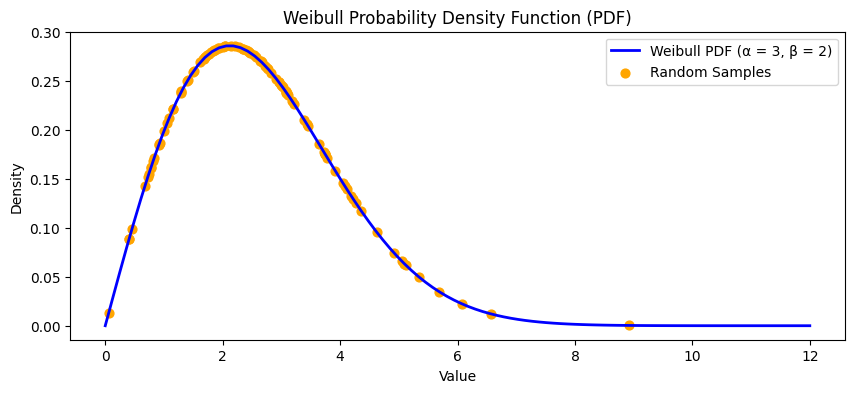

In [3]:
# Parameters for the Weibull distribution
alpha, beta = 3, 2
n_samples = 100

# Generate 100 random samples from the Weibull distribution
random_samples = weibull_min.rvs(beta, scale=alpha, size=n_samples)

# Calculate the probability (PDF) for each sample
random_sample_prob = weibull_min.pdf(random_samples, beta, scale=alpha)

# Zip together in format: (sample value, probability of value)
random_sample_list = list(zip(random_samples, random_sample_prob))

# Define range for plotting the PDF
x = np.linspace(0, 12, 100)  # Adjust the range as needed
y = weibull_min.pdf(x, beta, scale=alpha)

# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(x, y, label=f'Weibull PDF (α = {alpha}, β = {beta})', color='blue', linewidth=2)
plt.scatter([a for a, _ in random_sample_list], [p_a for _, p_a in random_sample_list], color='orange', label='Random Samples', marker='o', s=40)
plt.title('Weibull Probability Density Function (PDF)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

#### b. Formulating Stochastic Optimisation Problem

$$
\text{minimize } \sum_{i=1}^{k} p(a_i) \: a_i \: x_1  + x_2
$$

$$
\text{s.t.} \: a_i x_1 + x_2 \geq - M(1-y_i) \quad \forall i =1,2,...,k
$$

$$
\sum_{i=1}^{k} y_i \geq 90
$$

$$
0 \leq x_1 \leq 10, \quad 0 \leq x_2 \leq 10
$$

$$
y_i \in \{0, 1\} 
$$

where $p(a_i)$ is the probability density function (PDF) value for sample $ a_i $, and $M$ is some sufficiently large constant.

In [4]:
# Create a Pyomo model
model = ConcreteModel()

# Variables
model.x1 = Var(bounds=(1, 10), domain=PositiveReals)
model.x2 = Var(domain=Reals)
model.y = Var(range(n_samples), within=Binary)

# Objective Function
@model.Objective(sense=minimize)
def objective_rule(model):
    return sum((a * p_a * model.x1 + model.x2) for a, p_a in random_sample_list)

M = 100
# Loop to add multiple constraints based on uncertain values
def constraint_rule(model, i):
    a, _ = random_sample_list[i]  # Get 'a' from the sample_list
    return a * model.x1 + model.x2 >= - M * (1-model.y[i])

# Create constraints using a loop
model.constraints = ConstraintList()
for i in range(n_samples):
    model.constraints.add(constraint_rule(model, i))

# Sum of y constraint
model.sum_y_constraint = Constraint(expr=sum(model.y[i] for i in range(n_samples)) >=99)

# To solve the model
solver = SolverFactory('bonmin', executable= bonmin_executable)
results = solver.solve(model)
constraints_violated = n_samples - sum(model.y[i].value for i in range(n_samples))

print(f"x1 optimal: {model.x1.value:.1f}")
print(f"x2 optimal: {model.x2.value:.1f}")
print(f"Objective Value: {model.objective_rule():.0f}")
print(f"No. Constraint Violations: {constraints_violated:.0f}")

x1 optimal: 1.0
x2 optimal: -0.4
Objective Value: 8
No. Constraint Violations: 1


#### c. Importance Sampling - Capturing Samples at Tail

The above graph shows random sampling does not effectively capturing the tail end of the distribution. This is problematic when we want our solution to be robust to such extreme events, which may occur infrequently but can have a significant impact. 

A potential solution is to increase the number of random samples such that we eventually capture the tail end of the distribution. However, this would require a large number of samples, making the problem excessively large, increasing run time. 

Instead of excessively increasing the sample size, we can use importance sampling to focus on tail-end samples without allowing them to disproportionately influence the optimization. This technique adjusts each sample's contribution based on its likelihood in the true distribution, enabling a more effective representation of rare events.

In importance sampling, we use the importance factor $w(a)$, to weight the samples impact on our model. This factor is calculated for each sample, and is the PDF value of a given sample normalised by the samples' average PDF.

$$
w(a) = \frac{p(a)}{\bar{p}} \quad \text{where} \quad \bar{p} = \frac{1}{k}\sum_{i=1}^{k} p(a_i)
$$

Where:
- $p(a)$ is the PDF of the Weibull distribution.
- $\bar{p}$ is the average of the PDF calculated over $k$ samples.
- $w(a)$ is the importance factor that adjusts the contribution of each sample.

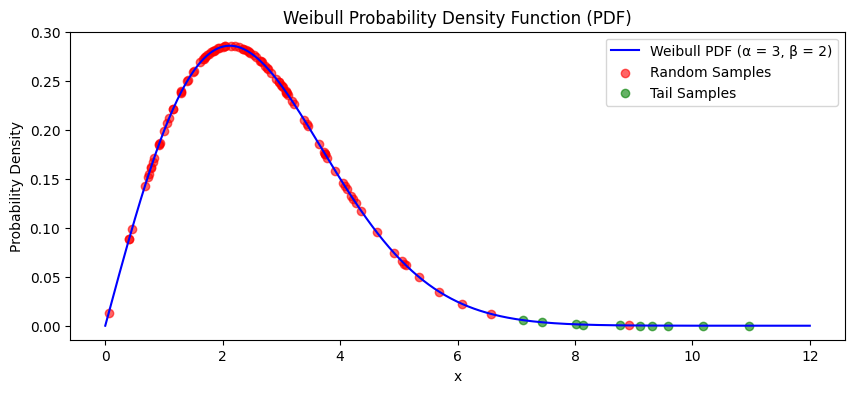

In [5]:
# Add 10 additional samples specifically targeting the tail
tail_samples = weibull_min.rvs(beta, scale=alpha, size=10) + 6  # shift to target tail
all_samples = np.concatenate((random_samples, tail_samples))

# Calculate the probability (PDF) for each sample
all_probabilities = weibull_min.pdf(all_samples, beta, scale=alpha)

# Calculate the importance factor for each sample (normalised by average PDF)
importance_factors = all_probabilities / np.mean(all_probabilities)

# Zip samples, probabilities, and importance factors together
sample_probability_importance_pairs = list(zip(all_samples, all_probabilities))

# Plot the Weibull distribution
x = np.linspace(0, 12, 500)
pdf = weibull_min.pdf(x, beta, scale=alpha)
plt.figure(figsize=(10, 4))
plt.plot(x, pdf, label=f'Weibull PDF (α = {alpha}, β = {beta})', color='blue')

# Plot the samples
plt.scatter(random_samples, weibull_min.pdf(random_samples, beta, scale=alpha), color='red', label='Random Samples', alpha=0.6)
plt.scatter(tail_samples, weibull_min.pdf(tail_samples, beta, scale=alpha), color='green', label='Tail Samples', alpha=0.6)
plt.title('Weibull Probability Density Function (PDF)')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

#### d. Optimisation Problem with Importance Samples

$$
\text{minimize } \sum_{i=1}^{k} p(a_i) \: a_i \: x_1  + x_2
$$

$$
\text{s.t.} \: a_i x_1 + x_2 \geq - M(1-y_i) \quad \forall i =1,2,...,k
$$

$$
\sum_{i=1}^{k} y_i \geq 90
$$

$$
0 \leq x_1 \leq 10, \quad 0 \leq x_2 \leq 10
$$

$$
y_i \in \{0, 1\} 
$$

where $p(a_i)$ is the probability density function (PDF) value for sample $ a_i $.

In [9]:
# Create a Pyomo model
model = ConcreteModel()

# Variables
model.x1 = Var(bounds=(1, 10), domain=PositiveReals)
model.x2 = Var(domain=Reals)
model.y = Var(range(len(all_samples)), bounds=(0, 1), within=Binary)

# Objective Function: Scale the contribution of each sample by its importance weight
@model.Objective(sense=minimize)
def objective_rule(model):
    return sum(importance_factors[i] * (a * p_a * model.x1 + model.x2)
                for i, (a, p_a) in enumerate(sample_probability_importance_pairs))

M = 100
# Loop to add multiple constraints based on uncertain values
def constraint_rule(model, i):
    a = all_samples[i]  # Get 'a' from the sample_list
    return a * model.x1 + model.x2 >= - M * (1-model.y[i])

# Create constraints using a loop
model.constraints = ConstraintList()
for i in range(len(all_samples)):
    model.constraints.add(constraint_rule(model, i))

# Sum of y constraint
model.sum_y_constraint = Constraint(expr=sum(model.y[i] for i in range(len(all_samples))) >= 110)

# To solve the model
solver = SolverFactory('cbc', executable=cbc_executable)
results = solver.solve(model)

print(f"x1 optimal: {model.x1.value:.1f}")
print(f"x2 optimal: {model.x2.value:.1f}")
print(f"Objective Value: {model.objective_rule():.0f}")
print(f"No. Constraint Violations: {constraints_violated:.0f}")

x1 optimal: 1.0
x2 optimal: -0.1
Objective Value: 52
No. Constraint Violations: 1


### 3. Robust Optimisation

$$
\text{minimize } a_i \: x_1  + x_2
$$

$$
\text{s.t.} \: a_i x_1 + x_2 \geq 0
$$

$$
0 \leq x_1 \leq 10, \quad 0 \leq x_2 \leq 10
$$


In [8]:
import pyomo.contrib.pyros as pyros

# Define the basic Pyomo model
model = ConcreteModel()

# Decision variables
model.x1 = Var(bounds=(1, 10), domain=PositiveReals)
model.x2 = Var(within=Reals)

# Define uncertain parameter a as a regular Param (mutable=False is default)
model.a = Param(initialize=1.0, mutable=True)

# Define the objective
model.obj = Objective(expr=model.a * model.x1 + model.x2, sense=minimize)

# Single constraint with parameter a
model.constr = Constraint(expr=model.a * model.x1 + model.x2 >= 0)

# Define the PyROS solver
pyros_solver = SolverFactory("pyros")

# Solve the robust optimization problem
results = pyros_solver.solve(
    model=model,
    first_stage_variables=[model.x1, model.x2],
    second_stage_variables=[],
    uncertain_params=[model.a],
    uncertainty_set=pyros.BoxSet(bounds=[(0, 13)]), 
    local_solver="ipopt",
    global_solver="ipopt",
    objective_focus=pyros.ObjectiveType.worst_case,
    solve_master_globally=True,
    load_solution=False,
)

print(f"\n========Final objective value: {results.final_objective_value:.2f}")
print(f"\n========{results.pyros_termination_condition}")


PyROS: Pyomo Robust Optimization Solver v.1.2.6 
Developed by: Natalie M. Isenberg (1), Jason A. F. Sherman (1), 
              John D. Siirola (2), Chrysanthos E. Gounaris (1) 
(1) Carnegie Mellon University, Department of Chemical Engineering 
(2) Sandia National Laboratories, Center for Computing Research

The developers gratefully acknowledge support from the U.S. Department of Energy's 
Institute for the Design of Advanced Energy Systems (IDAES) 
======================================== DISCLAIMER =======================================
PyROS is still under development. 
Please provide feedback and/or report any issues by opening a Pyomo ticket.

INFO: PyROS working on iteration 0...
INFO: PyROS working on iteration 1...
INFO: PyROS working on iteration 2...
INFO: Robust optimal solution identified. Exiting PyROS.

========Final objective value: 13.00

========pyrosTerminationCondition.robust_optimal
